In [21]:
#Load the required packages
import pennylane.numpy as np
import pennylane as qml
import time
import warnings
warnings.filterwarnings('ignore')

from qiskit import Aer, IBMQ, QuantumCircuit
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance

from qiskit.tools.jupyter import *
from qiskit.visualization import *

from qiskit.algorithms import MinimumEigensolverResult, VQE
from qiskit.algorithms.optimizers import SLSQP, SPSA


from qiskit_nature.algorithms import GroundStateEigensolver, VQEUCCFactory
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.circuit.library import UCC, UCCSD
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import BravyiKitaevMapper, JordanWignerMapper, ParityMapper
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

from qiskit_nature.settings import settings

settings.dict_aux_operators = True

In [25]:
def V_A_T(val):
    print(val)
    # Coordinates(val) are given in Angstrom
    Beh2 = [["Be", [0.0, 0.0, 0.0]],
            ["H", [-val, 0.0, 0.0]], 
            ["H", [val, 0.0, 0.0]]]
    #define the molecule using qiskit_nature.drivers        
    BeH2 = Molecule( 
        geometry=Beh2 , # The coordinates
        multiplicity=1, # 2*S + 1
        charge=0,
    )
    #define driver using qiskit_nature.drivers.second_quantization
    driver = ElectronicStructureMoleculeDriver(BeH2, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF) 

    properties = driver.run()
    num_alpha_electrons = properties.get_property('ParticleNumber').num_alpha
    num_beta_electrons = properties.get_property('ParticleNumber').num_beta
    num_spin_orbitals = int(properties.get_property('ParticleNumber').num_spin_orbitals)

    nuclear_rep_energy = properties.get_property('ElectronicEnergy').nuclear_repulsion_energy
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")


    #Now we remove/freeze the core orbital 1s of Be for the calculations
    # Define the active space around the Fermi level 
    transformer = ActiveSpaceTransformer(
        num_electrons=4, # Number of electrons in our active space
        num_molecular_orbitals=6, # Number of orbitals in our active space
    )

    # Now we can get the reduced electronic structure problem
    problem_reduced = ElectronicStructureProblem(driver, transformers=[transformer]) 

    # The second quantized Hamiltonian of the reduce problem
    second_q_ops_reduced = problem_reduced.second_q_ops()
    #Using paritymapper to take advantage of the Z2 symmetry of the system
    mapper = ParityMapper()

    converter = QubitConverter(mapper)

    qubit_op = converter.convert(second_q_ops_reduced["ElectronicEnergy"])
    #reduces the qubit number by 2
    parity_converter = QubitConverter(mapper, two_qubit_reduction=True)    

    # Compute the Hamitonian in qubit form
    qubit_op_parity = parity_converter.convert(second_q_ops_reduced.get('ElectronicEnergy'), num_particles=problem_reduced.num_particles)
    #Use UCCSD ansatz to look for single and double excitation on noiseless simulator
    vqe_factory = VQEUCCFactory( 
        quantum_instance=Aer.get_backend("aer_simulator_statevector"),
        optimizer=SLSQP(maxiter=6,ftol = 1e-4),
        ansatz=UCC(excitations='sd')
    ) 

    from qiskit.algorithms import NumPyMinimumEigensolver

    numpy_solver = NumPyMinimumEigensolver()

    #Find the real solution using classical method
    solver = GroundStateEigensolver(parity_converter, vqe_factory) 
    real_solution_t = solver.solve(problem_reduced).total_energies[0]    
    print('Reference energy : ', real_solution_t)
    symbols = ["H","Be","H"]
    geometry = np.array([ -val/0.529, 0.0, 0.0,0.0, 0.0, 0.0, val/0.529, 0.0, 0.0])
    #define the hamiltonian of the system
    hamil = qml.qchem.molecular_hamiltonian(symbols,geometry,charge = 0,basis = 'sto-3g', active_electrons=4, active_orbitals=6)[0]
    #number of qubits
    n_qubits = len(hamil.wires)

    #define the hf state
    hf_state = qml.qchem.hf_state(electrons=4, orbitals=n_qubits)
    # singles and doubles are used to make the AllSinglesDoubles template
    singles, doubles = qml.qchem.excitations(4, n_qubits)
    from qiskit.utils import algorithm_globals
    algorithm_globals.random_seed = 10



    dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev)


    def cost(weights):
        qml.BasisState(hf_state, wires=list(range(n_qubits)))
        for i in range(len(singles)):            
            qml.SingleExcitation(weights[i+len(doubles)], wires=singles[i])
        for i in range(len(doubles)):
            qml.DoubleExcitation(weights[i], wires=doubles[i])        
        return qml.expval(hamil)

    weights =np.zeros(len(doubles + singles), requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=0.05)
    i=0
    iter=[]
    cost_val=[]
    Lowest_E=0
    best_weights=0
    t1 = time.time()
    for _ in range(30):
        weights = opt.step(cost, weights)
        iter.append(i)
        cost_fn=cost(weights)
        if Lowest_E>cost_fn:
            Lowest_E=cost_fn
            best_weights=weights
        cost_val.append(cost_fn)
        #print('iter:',i,' cost_fn:',cost_fn)
        i=i+1
    t2 = time.time()
    print('VQE', cost_fn)
    VQE_val = cost_fn
    VQE_CNOT = 13*len(doubles) + 2*len(singles)
    VQE_t = t2-t1
    print('CNOT gates for VQE', VQE_CNOT)
    print('Time taken for optimization',t2-t1)
    
    '''
    # The following plot is of full VQE
    import matplotlib.pyplot as plt
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(cost_val, label="Estimator VQE BeH2 IDEAL")
    plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()
    '''

    #Define the symbol and geometry
    symbols = ["H","Be","H"]
    #Geometry in atomic distance for pennylane
    geometry = np.array([ -val/0.529, 0.0, 0.0,0.0, 0.0, 0.0, val/0.529, 0.0, 0.0])
    active_electrons = 4
    H, qubits = qml.qchem.molecular_hamiltonian(
        symbols,
        geometry,
        active_electrons=active_electrons,
        active_orbitals=6
    )
    
    def circuit_1(params, excitations):
        qml.BasisState(hf_state, wires=range(qubits))

        for i, excitation in enumerate(excitations):
            if len(excitation) == 4:
                qml.DoubleExcitation(params[i], wires=excitation)
            else:
                qml.SingleExcitation(params[i], wires=excitation)
        return qml.expval(H)
    dev = qml.device("default.qubit", wires=qubits)
    cost_fn = qml.QNode(circuit_1, dev)

    circuit_gradient = qml.grad(cost_fn, argnum=0)

    params = [0.0] * len(doubles)
    grads = circuit_gradient(params, excitations=doubles)
    doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
    opt = qml.GradientDescentOptimizer(stepsize=0.5)

    params_doubles = np.zeros(len(doubles_select), requires_grad=True)

    for n in range(20):
        params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
    def circuit_2(params, excitations, gates_select, params_select):
        qml.BasisState(hf_state, wires=range(qubits))

        for i, gate in enumerate(gates_select):
            if len(gate) == 4:
                qml.DoubleExcitation(params_select[i], wires=gate)
            elif len(gate) == 2:
                qml.SingleExcitation(params_select[i], wires=gate)

        for i, gate in enumerate(excitations):
            if len(gate) == 4:
                qml.DoubleExcitation(params[i], wires=gate)
            elif len(gate) == 2:
                qml.SingleExcitation(params[i], wires=gate)
        return qml.expval(H)
    cost_fn = qml.QNode(circuit_2, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    params = [0.0] * len(singles)

    grads = circuit_gradient(
        params,
        excitations=singles,
        gates_select=doubles_select,
        params_select=params_doubles
    )
    singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5 ]
    cost_fn = qml.QNode(circuit_1, dev)

    params = np.zeros(len(doubles_select + singles_select), requires_grad=True)

    gates_select = doubles_select + singles_select
    energy_vals = []
    t3 = time.time()
    for n in range(20):        
        params, energy = opt.step_and_cost(cost_fn, params, excitations=gates_select)
        
        energy_vals.append(energy)
        #print("n = {:},  E = {:.8f} H, t = {:.2f} s".format(n, energy, t2 - t1))
    t4 = time.time()
    ADAPT_val = energy
    ADAPT_t = t4-t3
    ADAPT_CNOT = 13*len(doubles_select) + 2*len(singles_select)
    print('ADAPT_VQE', energy)
    print('Time taken for optimization',t4-t3)
    
    print('Number of CNOT used', ADAPT_CNOT)
    '''
    # The following plot is of ADAPT_VQE
    import matplotlib.pyplot as plt
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(energy_vals, label="ADAPT VQE BeH2 IDEAL")
    plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()
    '''
    



    #Define the symbol and geometry
    symbols = ["H","Be","H"]
    #Geometry in atomic distance for pennylane
    geometry = np.array([ -val/0.529, 0.0, 0.0,0.0, 0.0, 0.0, val/0.529, 0.0, 0.0])
    active_electrons = 4

    

    #all the operators together
    all_operators=singles+doubles

    params = [0.0] * len(doubles+singles)
    params=np.array(params )

    #define the circuit again
    def circuit_1(params, excitations):
            qml.BasisState(hf_state, wires=range(n_qubits))

            for i, excitation in enumerate(excitations):
                if len(excitation) == 4:
                    qml.DoubleExcitation(params[i], wires=excitation)
                else:
                    qml.SingleExcitation(params[i], wires=excitation)
            return qml.expval(H )



    dev = qml.device("default.qubit", wires=n_qubits)
    cost_fn = qml.QNode(circuit_1, dev)
    circuit_gradient = qml.grad(cost_fn, argnum=0)
    grads = circuit_gradient(params, excitations=doubles+singles)

    #operators in the opposite manner
    opposite_pool=doubles+singles

    #Thresholding the excitations
    new_opposite_pool=[opposite_pool[idx] for idx in range(len(grads)) if abs(grads[idx]) >1e-5]
    #gradients for the excitations thresholded
    new_grads=[grads[idx] for idx in range(len(grads)) if abs(grads[idx]) > 1e-5]

    #Now we sort these gradients and we will apply it sequentially
    indx=np.argsort(np.abs(new_grads))
    sorted_opposite_pool=[new_opposite_pool[idx] for idx in indx]

    #For the shallower circuit, we will use this
    shallow_circuits=[]    
    while len(sorted_opposite_pool) !=0:
        q_layer=[]     
        ind_left=[]  
        for idx, op in enumerate(sorted_opposite_pool):
            if shallow_circuits==[]:
                shallow_circuits.append(op)
                q_layer=q_layer+op
            else:
                Stack=True
                for k in op:
                    if k in q_layer:
                        Stack=False
                        ind_left.append(idx)
                        break
                if Stack:
                    shallow_circuits.append(op)
                    q_layer=q_layer+op
        sorted_opposite_pool=[sorted_opposite_pool[idx] for idx in ind_left]

    params = [0.0] * len(doubles_select+singles_select)
    params=np.array(params )

    q_layer=[]
    time_iterations=20
    conv_tol=1e-4
    energy=[]

    opt = qml.GradientDescentOptimizer(stepsize=0.3) 
    dev = qml.device("default.qubit", wires=n_qubits)

    cost_fn = qml.QNode(circuit_1, dev, expansion_strategy="device")
    circuit_gradient = qml.grad(cost_fn, argnum=0) # step 2.

    energy = [cost_fn(params, shallow_circuits)] # step 2.
    print(f"time_iteration = 0,  Energy = {energy[-1]:.8f} Ha")
    print("Number of gates = {}\n".format(len(shallow_circuits)))
    configs=qml.specs(cost_fn)(params, excitations=shallow_circuits)
    print("Circuit Depth = {}\n".format(configs['depth'],))
    t5 = time.time()
    for n in range(time_iterations):

        Test_set=shallow_circuits+all_operators
        Test_parameters=list(params)+[0.0]*len(all_operators)
        Test_parameters=np.array(Test_parameters)

        test_grads = circuit_gradient(Test_parameters,Test_set)
        test_grads = test_grads[len(params):]

        test_sorted_indx=np.argsort(np.abs(test_grads))[::-1]
        maxpos=test_sorted_indx[0]
        Larger_sorted_indx=[]
        for ind in test_sorted_indx:
            Larger_sorted_indx.append(ind)

        for k,ind in enumerate(Larger_sorted_indx):
            op_set=set(all_operators[ind])
            q_layer_set=set(q_layer)
            if not bool(op_set & q_layer_set):
                q_layer=q_layer+all_operators[ind]
                shallow_circuits.append(all_operators[ind])
                params=np.append(params, 0.0)
            if (len(q_layer)>=n_qubits-4): # It is hard to find the operators with non-zero gradient fill all qubit layers.
                q_layer=[]                                 # We leave at maximum 4 idle qubits
                break


        params,_ = opt.step(cost_fn, params, shallow_circuits) # Step 5.
        E_val=cost_fn(params, shallow_circuits)
        energy.append(E_val)
        conv = np.abs(real_solution_t.real - E_val) #step 3.

        #print(f"time_iteration = {n+1}, Energy = {energy[-1]:.8f} Ha")
        #print("Number of gates = {}\n".format(len(shallow_circuits)))
        configs=qml.specs(cost_fn)(params, excitations=shallow_circuits)
        #print("Circuit Depth = {}\n".format(configs['depth'],))
        if conv <= conv_tol:
            break
    t6 = time.time()
    TETRIS_val = energy[-1]
    TETRIS_time = t6-t5
    num_two_gates = 0
    for ele in shallow_circuits:
        if len(ele)==2:
            num_two_gates+=2
        else:
            num_two_gates+=13
    TETRIS_CNOT = num_two_gates
    print('TETRIS energy value is',TETRIS_val)
    print('Time taken by TETRIS',TETRIS_time)
    print('Number of CNOT used', TETRIS_CNOT)
    '''
    plt.rcParams["font.size"] = 14

    # plot loss and reference value
    plt.figure(figsize=(12, 6), facecolor='white')
    plt.plot(cost_val[:20], label="VQE")
    plt.plot(energy_vals, label="ADAPT_VQE")
    plt.plot(energy, label="TETRIS_ADAPT_VQE")
    plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

    plt.legend(loc="best")
    plt.xlabel("Iteration")
    plt.ylabel("Energy [H]")
    plt.title("VQE energy")
    plt.show()
    '''
    return VQE_val, VQE_t, VQE_CNOT, ADAPT_val, ADAPT_t, ADAPT_CNOT, TETRIS_val, TETRIS_time, TETRIS_CNOT

In [23]:
vals = np.linspace(0.7,2.1,8)

In [26]:
data_points = []
for val in vals:
    data_points.append([V_A_T(val)])

Reference energy :  (-14.870603238171729+0j)
VQE -14.870821609812392
CNOT gates for VQE 1020
Time taken for optimization 231.13687014579773
ADAPT_VQE -14.871463700649992
Time taken for optimization 41.37842082977295
Number of CNOT used 190
time_iteration = 0,  Energy = -14.84232214 Ha
Number of gates = 14

Circuit Depth = 9

time_iteration = 1, Energy = -14.85536861 Ha
Number of gates = 16

Circuit Depth = 10

time_iteration = 2, Energy = -14.86146392 Ha
Number of gates = 18

Circuit Depth = 11

time_iteration = 3, Energy = -14.86476227 Ha
Number of gates = 20

Circuit Depth = 12

time_iteration = 4, Energy = -14.86673303 Ha
Number of gates = 22

Circuit Depth = 13

time_iteration = 5, Energy = -14.86799497 Ha
Number of gates = 24

Circuit Depth = 14

time_iteration = 6, Energy = -14.86884505 Ha
Number of gates = 26

Circuit Depth = 15

time_iteration = 7, Energy = -14.86944010 Ha
Number of gates = 28

Circuit Depth = 16

time_iteration = 8, Energy = -14.86986905 Ha
Number of gates = 3

In [43]:
vqe_val = []
adapt_val = []
tetris_val = []
vqe_t = []
adapt_t = []
tetris_t = []
vqe_cnot = []
adapt_cnot = []
tetris_cnot = []
for i in range(7):
    vqe_val.append(data_points[i][0][0])
    adapt_val.append(data_points[i][0][3])
    tetris_val.append(data_points[i][0][6])
    vqe_t.append(data_points[i][0][1])
    adapt_t.append(data_points[i][0][4])
    tetris_t.append(data_points[i][0][7])
    vqe_cnot.append(data_points[i][0][2])
    adapt_cnot.append(data_points[i][0][5])
    tetris_cnot.append(data_points[i][0][8])

In [ ]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(vqe_val, label="VQE")
plt.plot(adapt_val, label="ADAPT_VQE")
plt.plot(tetris_val, label="TETRIS_ADAPT_VQE")
#plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Bond Length")
plt.ylabel("Energy [H]")
plt.title("Different VQE energy")
plt.xticks([0,1,2,3,4,5,6,7],[0.7, 0.9,1.1,1.3,1.5,1.7,1.9,2.1])
plt.savefig('Energy_diff_bond_length.png')
plt.show()

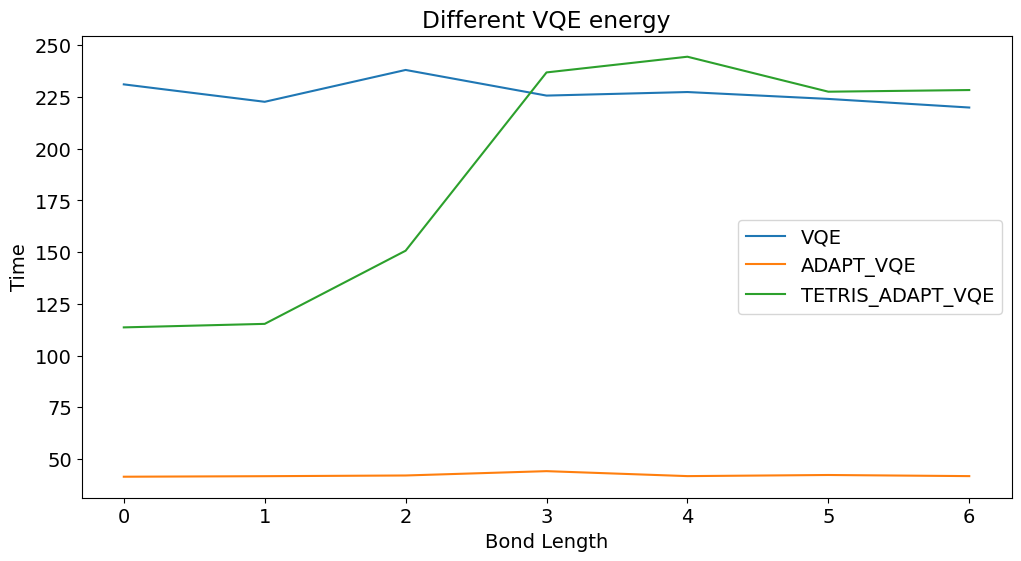

In [53]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(vqe_t, label="VQE")
plt.plot(adapt_t, label="ADAPT_VQE")
plt.plot(tetris_t, label="TETRIS_ADAPT_VQE")
#plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Bond Length")
plt.ylabel("Time")
plt.title("Time taken by different methods")
plt.show()

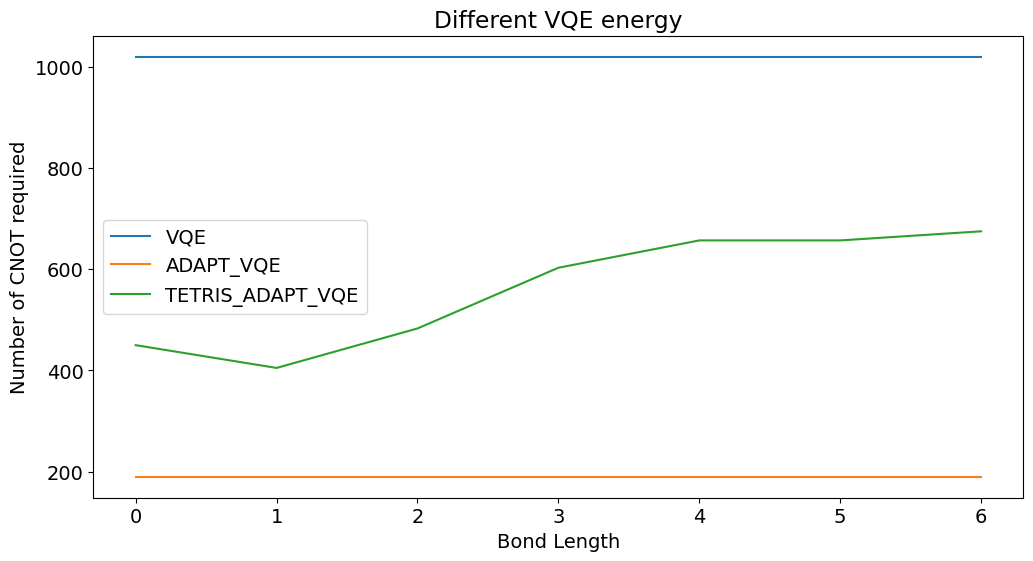

In [54]:
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(vqe_cnot, label="VQE")
plt.plot(adapt_cnot, label="ADAPT_VQE")
plt.plot(tetris_cnot, label="TETRIS_ADAPT_VQE")
#plt.axhline(y=real_solution_t.real, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Bond Length")
plt.ylabel("Number of CNOT required")
plt.title("Different VQE energy")
plt.show()